In [30]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os
import random

print(tf.__version__)

2.15.0


In [2]:
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [6]:
dirpath = 'kagglecatsanddogs_5340/PetImages/Dog/'
filenames = [dirpath+filename for filename in os.listdir(dirpath) if filename.endswith(".jpg")]

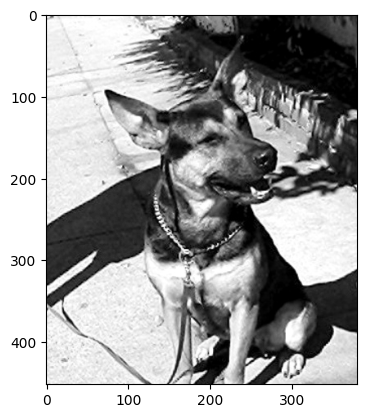

In [51]:
sample = random.choice(filenames)
image = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.show()

In [64]:
mean_size = np.zeros(2)
cnt = 0
for filename in filenames:
    try:
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        mean_size += image.shape
    except:
        print(filename)
    
    cnt += 1
    
mean_size /= cnt
print(mean_size)

kagglecatsanddogs_5340/PetImages/Dog/10158.jpg
kagglecatsanddogs_5340/PetImages/Dog/10401.jpg
kagglecatsanddogs_5340/PetImages/Dog/10747.jpg
kagglecatsanddogs_5340/PetImages/Dog/10797.jpg
kagglecatsanddogs_5340/PetImages/Dog/11410.jpg
kagglecatsanddogs_5340/PetImages/Dog/11675.jpg
kagglecatsanddogs_5340/PetImages/Dog/11702.jpg
kagglecatsanddogs_5340/PetImages/Dog/11849.jpg
kagglecatsanddogs_5340/PetImages/Dog/11853.jpg
kagglecatsanddogs_5340/PetImages/Dog/1308.jpg
kagglecatsanddogs_5340/PetImages/Dog/1866.jpg
kagglecatsanddogs_5340/PetImages/Dog/2384.jpg
kagglecatsanddogs_5340/PetImages/Dog/2688.jpg
kagglecatsanddogs_5340/PetImages/Dog/2877.jpg
kagglecatsanddogs_5340/PetImages/Dog/3136.jpg
kagglecatsanddogs_5340/PetImages/Dog/3288.jpg
kagglecatsanddogs_5340/PetImages/Dog/3588.jpg
kagglecatsanddogs_5340/PetImages/Dog/4367.jpg
kagglecatsanddogs_5340/PetImages/Dog/5604.jpg
kagglecatsanddogs_5340/PetImages/Dog/5736.jpg
kagglecatsanddogs_5340/PetImages/Dog/6059.jpg
kagglecatsanddogs_5340/Pe

### Detect objects (dogs) in images and crop them

In [67]:
import tensorflow_hub as hub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [72]:
import time

def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

def run_detector(detector, path):
    img = load_img(path)
    
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    
    result = {key:value.numpy() for key,value in result.items()}
    
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time-start_time)
        
    print(result["detection_class_entities"])
    
    dog_index = np.where(result["detection_class_entities"] == b'Dog')[0][0]
    
    print('Dog index: ', dog_index)
    ymin, xmin, ymax, xmax = tuple(result["detection_boxes"][dog_index])
    im_width, im_height = img.size

    left, right, top, bottom = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    print()
    
    # print(result["detection_scores"])
    # print('Boxed areas:')
    # print(result["detection_boxes"])
    
    return left, right, top, bottom

In [73]:
left, right, top, bottom = run_detector(detector, sample)

Found 100 objects.
Inference time:  5.988326072692871
[b'Dog' b'Plant' b'Plant' b'Fish' b'Dog' b'Clothing' b'Plant' b'Fish'
 b'Fashion accessory' b'Dog' b'Carnivore' b'Plant' b'Fish' b'Fish' b'Dog'
 b'Plant' b'Clothing' b'Plant' b'Human hand' b'Plant' b'Plant' b'Plant'
 b'Plant' b'Plant' b'Mammal' b'Human hand' b'Plant' b'Fish'
 b'Fashion accessory' b'Human leg' b'Clothing' b'Plant' b'Plant' b'Tree'
 b'Person' b'Fashion accessory' b'Plant' b'Dog' b'Dog' b'Plant' b'Animal'
 b'Clothing' b'Flower' b'Dog' b'Carnivore' b'Plant' b'Clothing' b'Plant'
 b'Dog' b'Plant' b'Fashion accessory' b'Plant' b'Chair' b'Mammal'
 b'Fashion accessory' b'Fish' b'Human arm' b'Human leg' b'Clothing'
 b'Plant' b'Human leg' b'Fashion accessory' b'Clothing' b'Clothing'
 b'Fish' b'Fish' b'Plant' b'Human arm' b'Furniture' b'Plant' b'Human arm'
 b'Toy' b'Furniture' b'Footwear' b'Furniture' b'Human leg' b'Human arm'
 b'Plant' b'Human arm' b'Human arm' b'Clothing' b'Hiking equipment'
 b'Plant' b'Clothing' b'Plant' b'T

In [ ]:
image = cv2.imread(sample, cv2.IMREAD_GRAYSCALE)

cropped_image = image[top:bottom, left:right]

cv2.imwrite('cropped_image.jpg', cropped_image)

In [ ]:
def make_square(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)

    # Get image dimensions
    height, width = image.shape[:2]

    # Determine the longer side and the difference
    max_side = max(height, width)
    top = bottom = left = right = 0

    if height < max_side:
        diff = max_side - height
        top = diff // 2
        bottom = diff - top
    elif width < max_side:
        diff = max_side - width
        left = diff // 2
        right = diff - left

    # Add padding to the image
    padded_image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Save or display the padded image
    cv2.imwrite(output_path, padded_image)
    # You can also display the image using cv2.imshow
    # cv2.imshow("Padded Image", padded_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    
make_square('path_to_your_image.jpg', 'output_image.jpg')

In [52]:
preprocessed_dirpath = 'kagglecatsanddogs_5340/PetImages/Dog-preprocessed/'

if not os.path.exists(preprocessed_dirpath):
    os.makedirs(preprocessed_dirpath)
    
for filename in filenames[:2]:
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, IMAGE_SIZE)
    cv2.imwrite(preprocessed_dirpath+filename.split('/')[-1], image)